# Student Success and Failure Lookalike Project
## Intro
School is one of the best ways to raise individuals' earnings potentials. If we can identify students who are at risk in school, it's possible we could intervene beforehand. If we can identify "lookalike's" of students that fail, we could intervene with these students and tailor solutions based on identifiers.

_"A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies. The dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. The data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes._

_Data Source: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success_

## Problem Statement
In 2023 about 9.5% of students were "early leavers" in EU from education and training. This can be a critical moment for individuals' career success. This is much higher for men than women. Most early leavers do not have work when they leave. _Source: [EU Eurostate](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Early_leavers_from_education_and_traininghttps://ec.europa.eu/eurostat/statistics-explained/index.php?title=Early_leavers_from_education_and_training)_.

## Proposed Solution
If we can identify students who are at risk of dropout in higher education, it's possible institutions could intervene beforehand or better prepare students for the education journey. It could also help institutions predict which students will be successful in higher ed.

## Dataset
The Polytechnic Institute of Portalegre and SATDAP (Capacitação da Administração Pública) created a dataset to identify which students would graduate or leave their institution. _Note: While this group certainly did their own prediction, I have not and will not read the paper until after I complete my own data model._

Citation: M.V.Martins, D. Tolledo, J. Machado, L. M.T. Baptista, V.Realinho. (2021) "Early prediction of student’s performance in higher education: a case study" Trends and Applications in Information Systems and Technologies, vol.1, in Advances in Intelligent Systems and Computing series. Springer. DOI: 10.1007/978-3-030-72657-7_16



<div style="margin-left: 50px;">
    <img src="./poly_screenshot.png" width="600" />
</div>

## Target Variable
Our target variable for this exercise is the "Target" column that contains labels for Graduate (2), Enrolled (1), and Dropout (0).

# Outline
- [Imports/Data Exploration](#Imports/Data-Exploration)
- [Modeling](#Modeling)
- [Evaluating](#Evaluating)
- [Brief Error Analysis](#Brief-Error-Analysis)

# Imports/Data Exploration

In [21]:
#%load_ext autoreload
#%autoreload 2

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import joblib
import importlib

#Suppress FutureWarnings from pandas and seaborn
warnings.simplefilter(action='ignore', category=FutureWarning)

Let's take a quick look at our data!

In [23]:
#pulling in the data for an initial first pass
datapath = './data/student_data.csv'
raw_df = pd.read_csv(datapath, low_memory=False, delimiter=';')
print(raw_df.shape)
display(raw_df.head())
display(raw_df.info())

(4424, 37)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

None

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(raw_df['Target'])
target_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Target Column Conversion: {target_map}")

def target_mapping(x):
    y = target_map[x]
    return(y)

raw_df["Target"] = raw_df["Target"].apply(target_mapping)
#display(raw_df.head())

dist_of_targ = raw_df.reset_index()[['Target','index']].groupby('Target').count().reset_index()
dist_of_targ['percent'] = dist_of_targ['index'].div(dist_of_targ['index'].sum())
display(dist_of_targ)

Target Column Conversion: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}


,Target,index,percent
0,0,1421,0.321203
1,1,794,0.179476
2,2,2209,0.499322


We can see there's a large imbalance between classes 1 and 0,2.

# Exploration
Let's plot some variables to see what our data looks like: 
- Histogram of our features
- Histogram split by target category.

The three that seem to offer the most insight in terms of our target are:
- __Marital status__ - Single and married students (values 1 and 2) are less likely to be enrolled status than other Marital statuses. However this is also a long tail distribution.
- __Admission grade__ - Dropout data might have an error in it. Admission grades 100, 120, 130, and 140 have an outsized share of dropout students.
- __Tuition fees up to date__ - Enrolled and graduate students are almost exclusively up to date with their tuition and fees while dropouts can appear as up to date or behind.

In [7]:
from utilWidgets import utilWidgets

# A plotting function that we'll use shortly
def HistAndBar(data, column, target="Target"):
    #warnings.simplefilter("ignore", category=UserWarning)
    fig, axes = plt.subplots(1,2, figsize=(7,4))
    sns.histplot(data=data, x=column, ax=axes[0], bins = 10)
    axes[0].set_title(f"Hist: {column}")
    sns.countplot(data=data, x=column, hue=target, ax=axes[1])
    axes[1].set_title(f"Bar: {column} and {target}")
    #axes[1].set_xticklabels(axes[1].get_xticks(), rotation=90)
    plt.show()
    
    # Now, show the widgets for marking the distribution
    #markings = utilWidgets().mark_distribution(column=column, data=data).distribution_choices
    #display(markings)
    #return(markings)

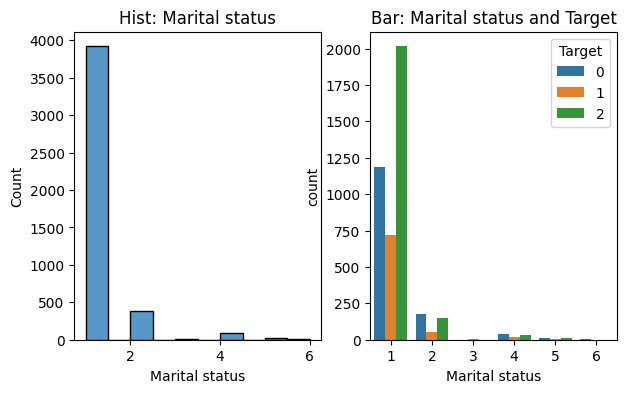

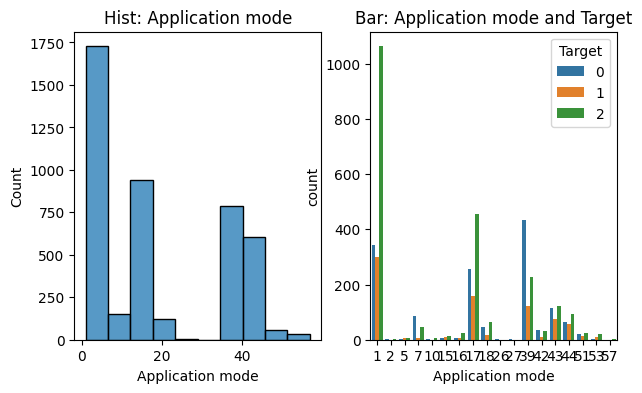

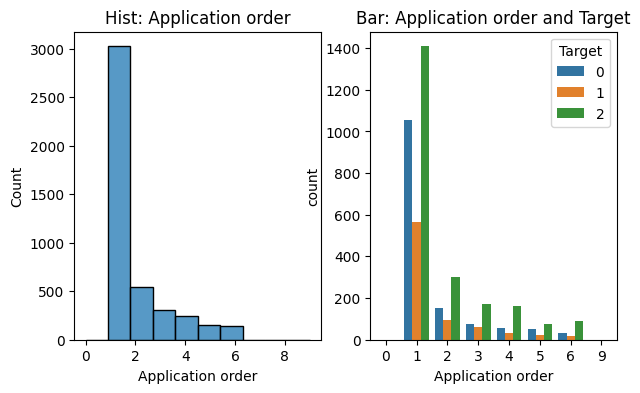

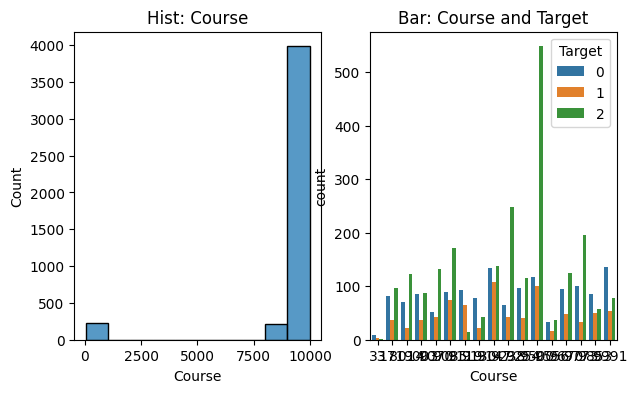

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


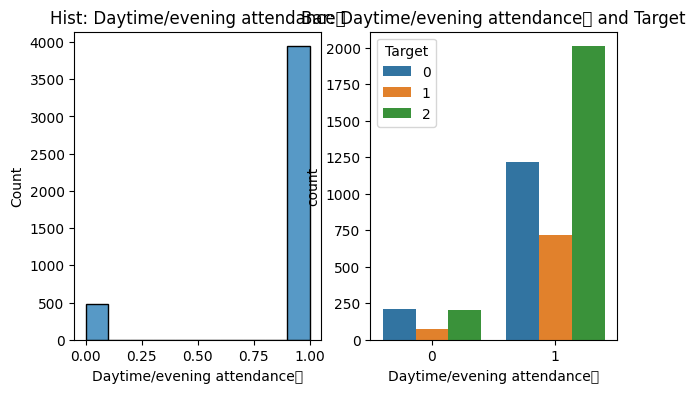

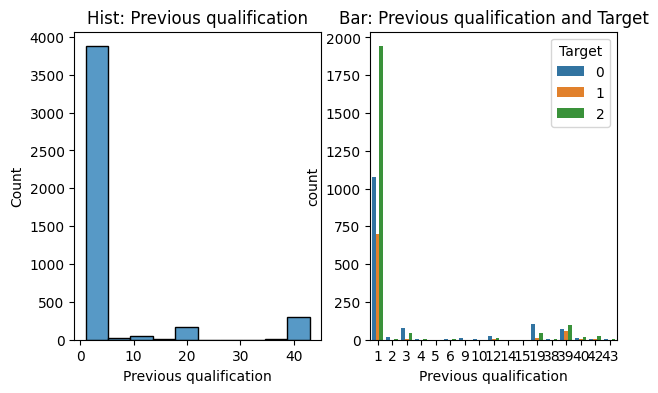

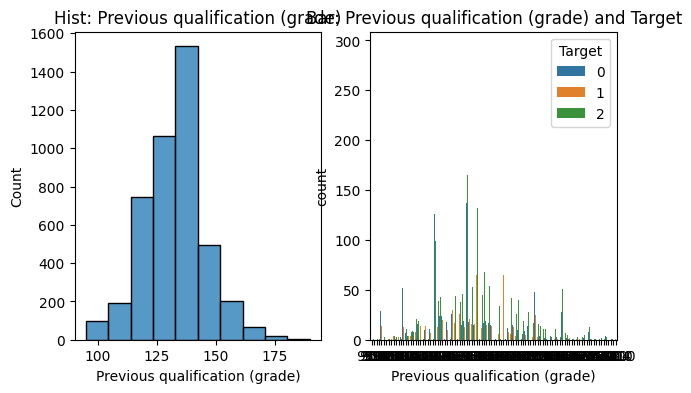

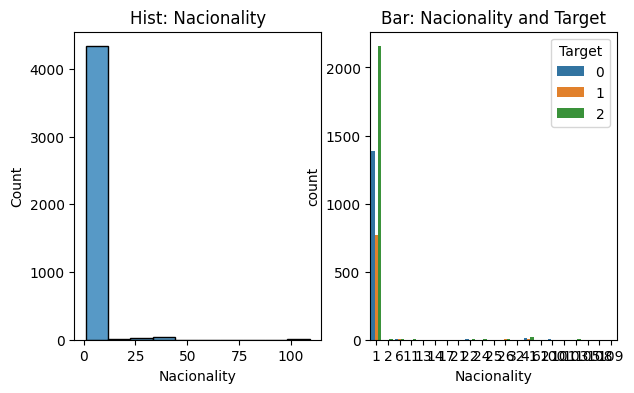

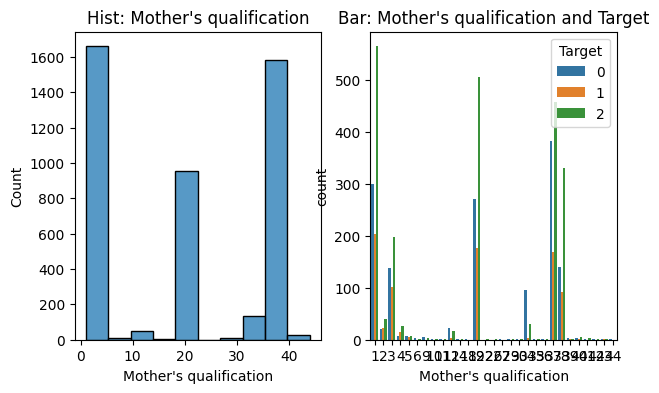

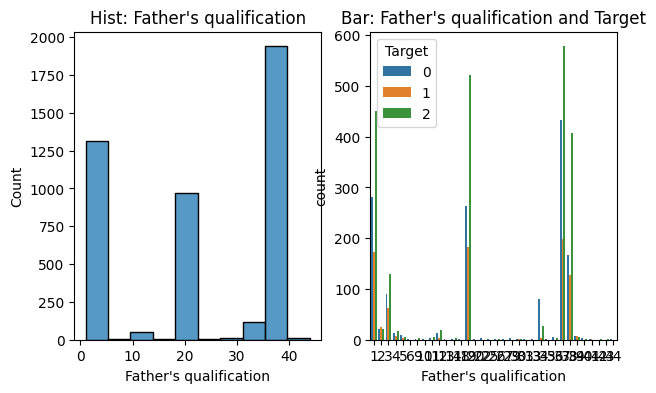

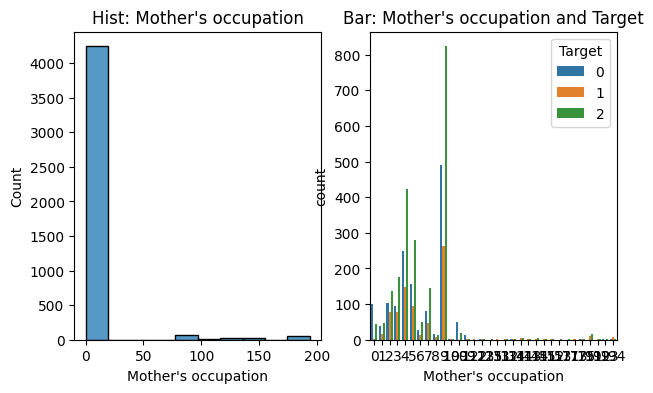

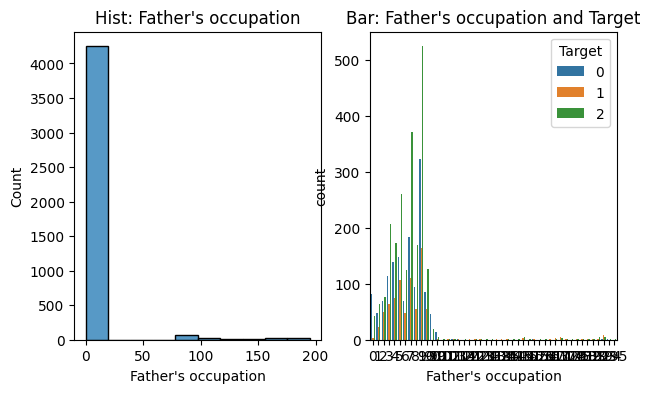

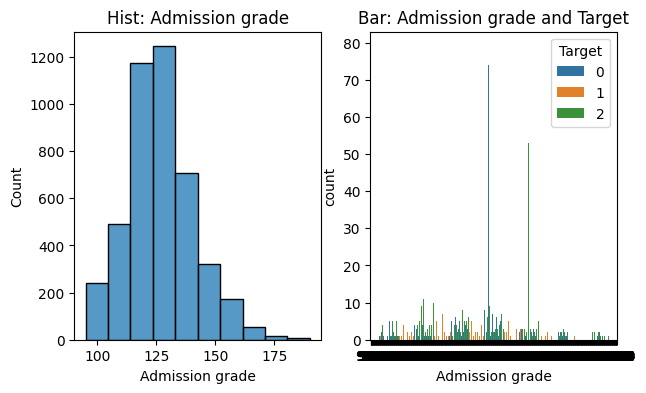

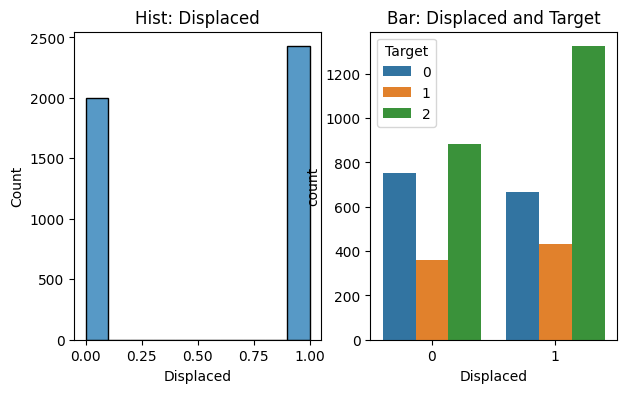

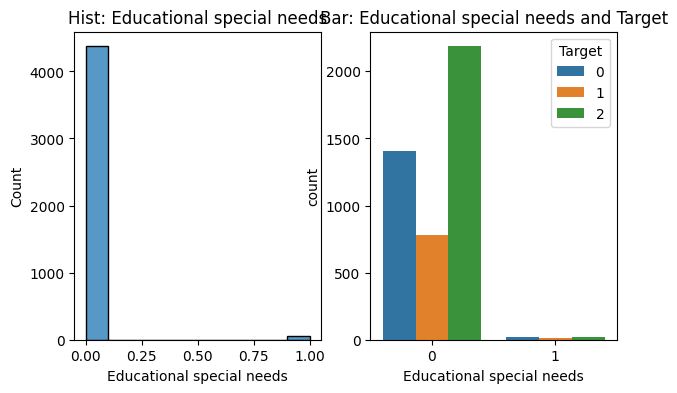

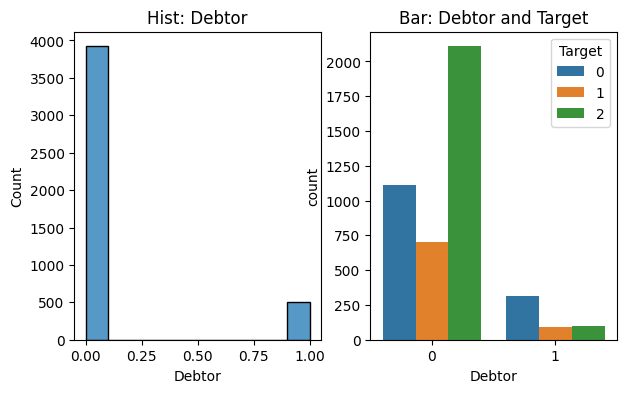

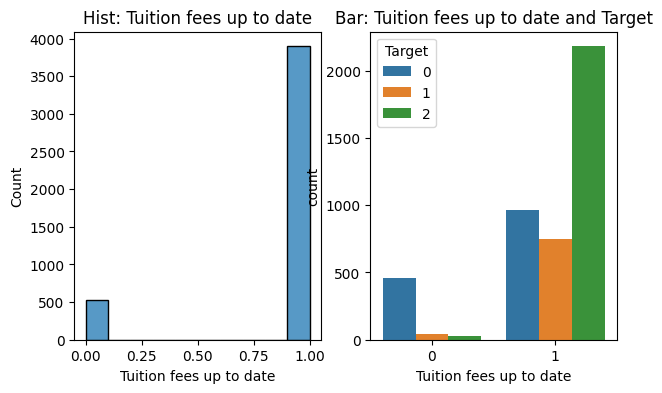

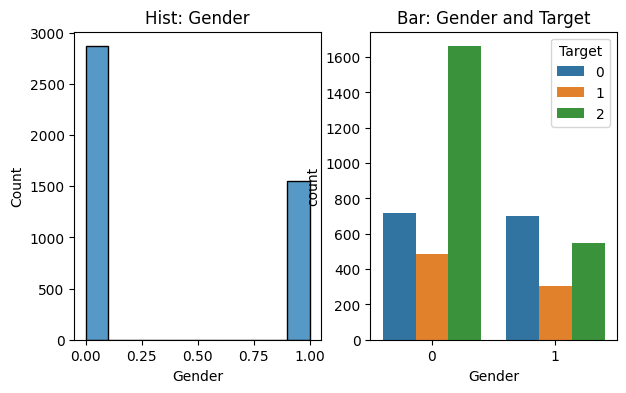

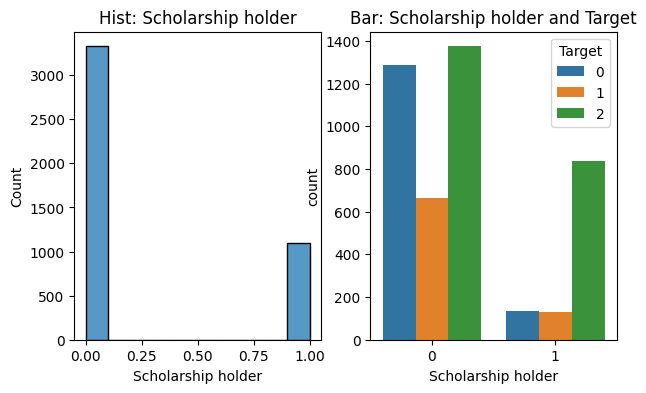

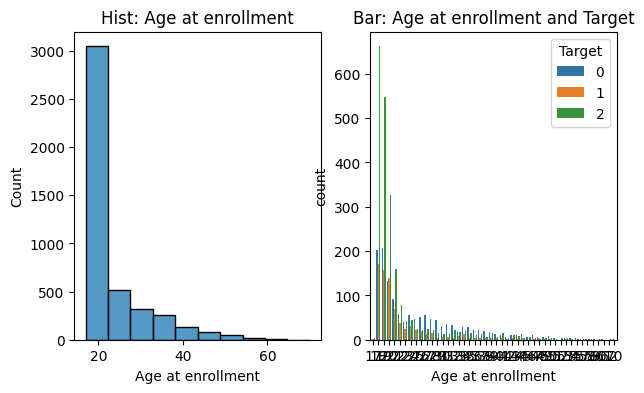

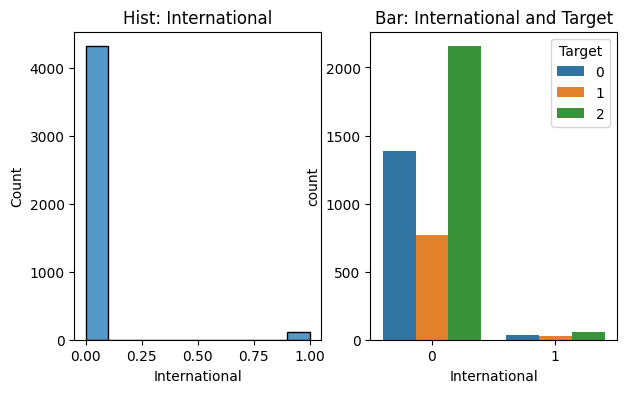

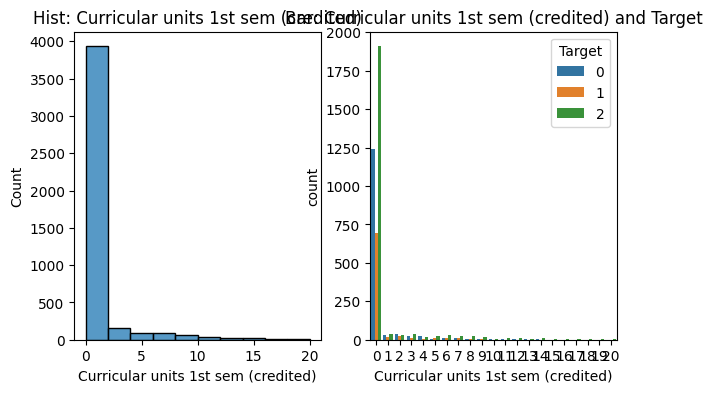

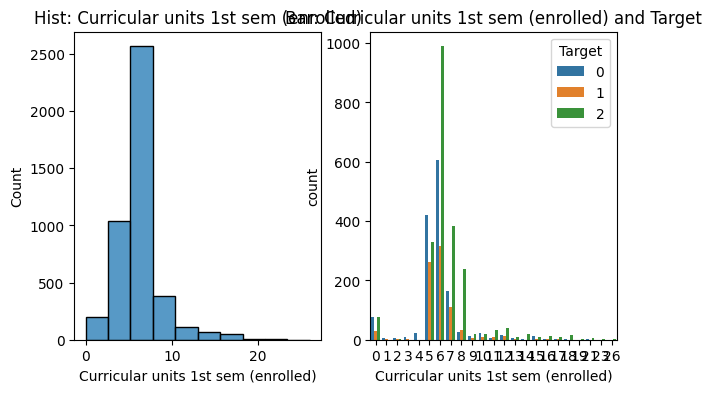

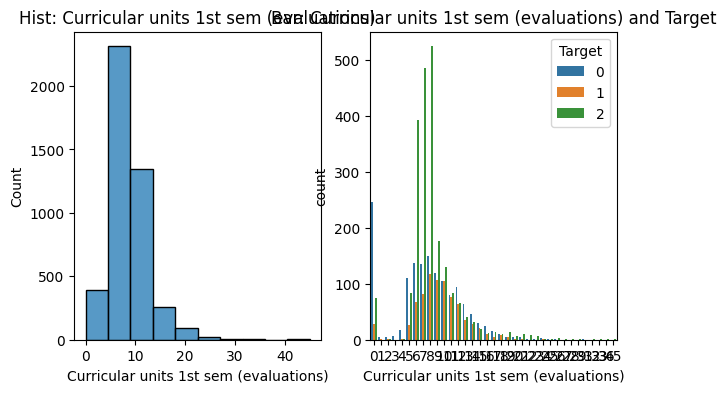

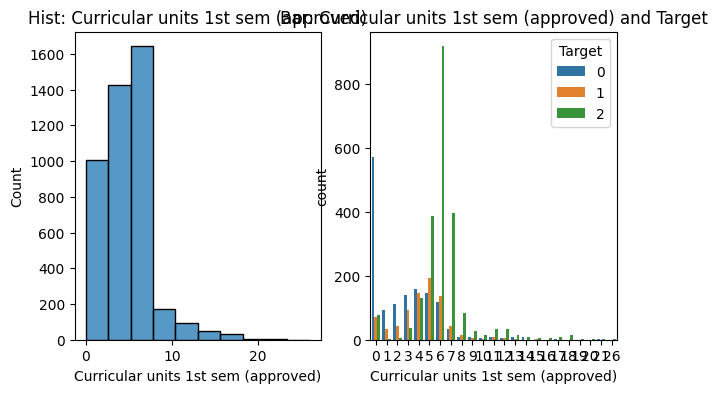

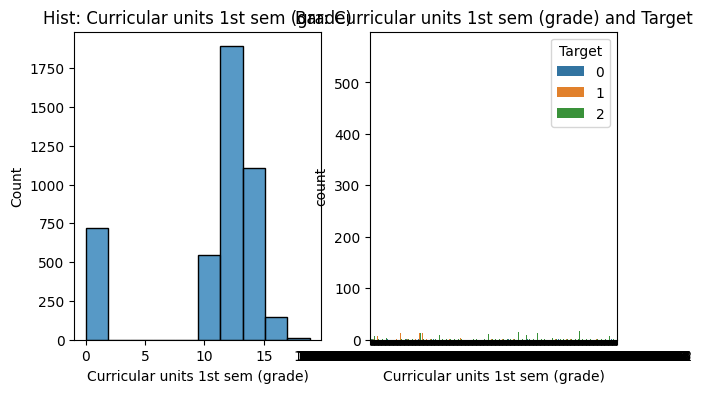

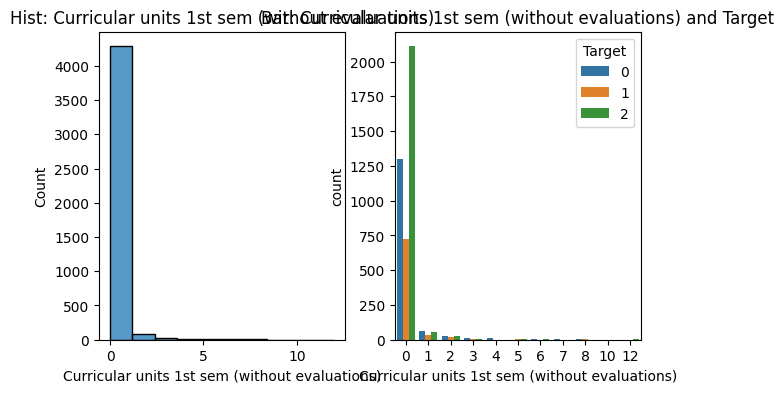

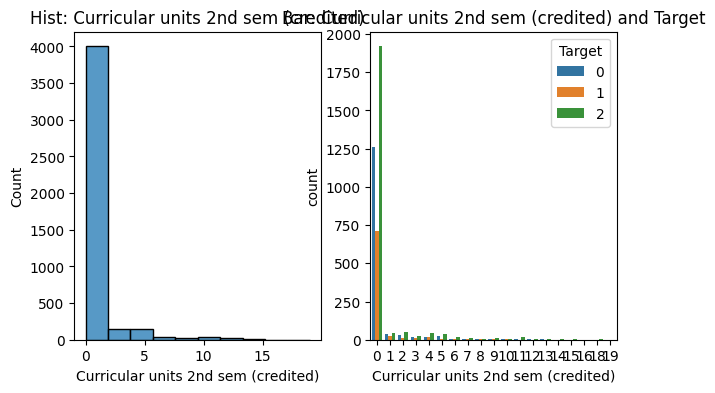

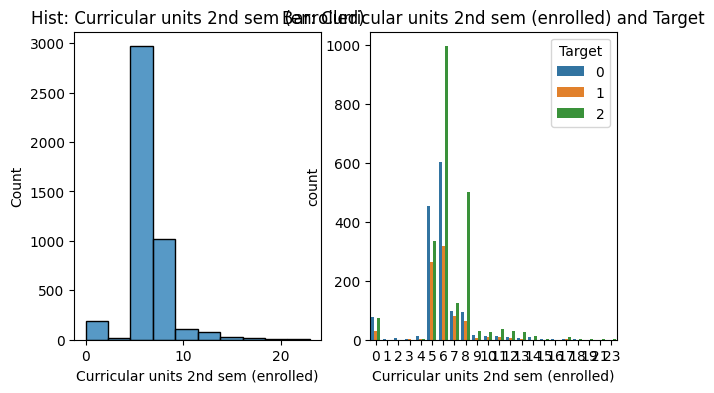

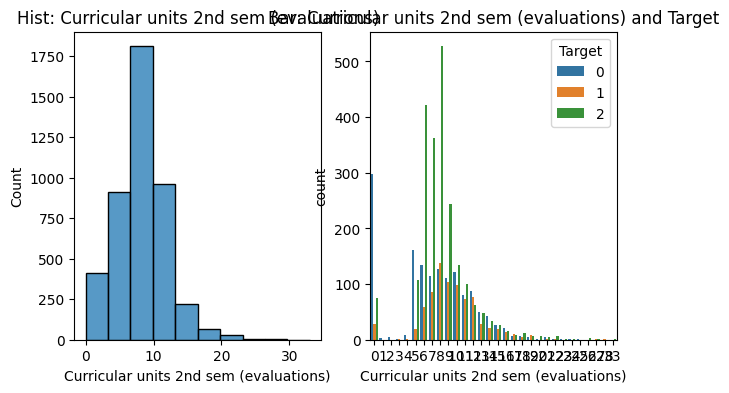

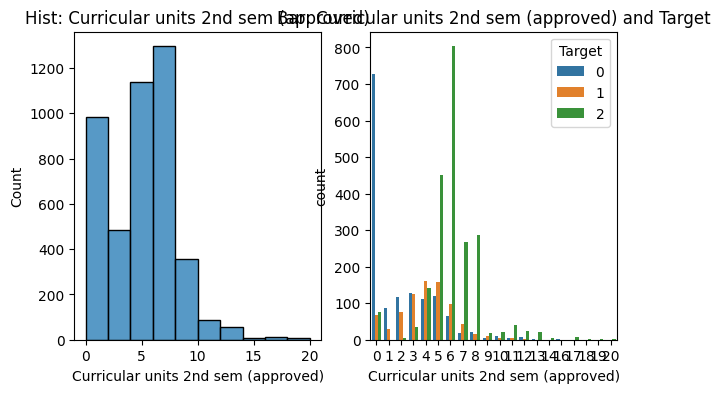

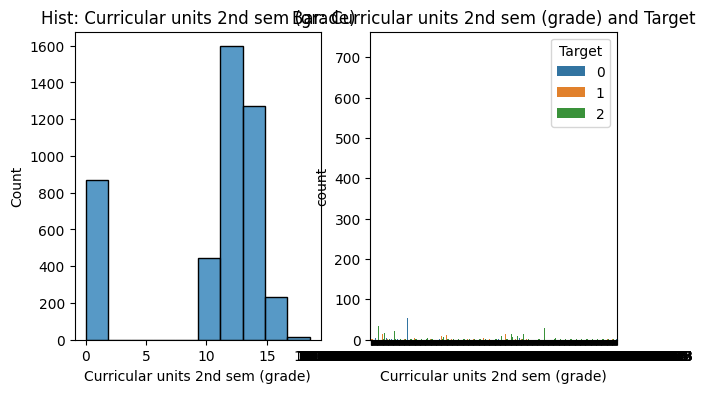

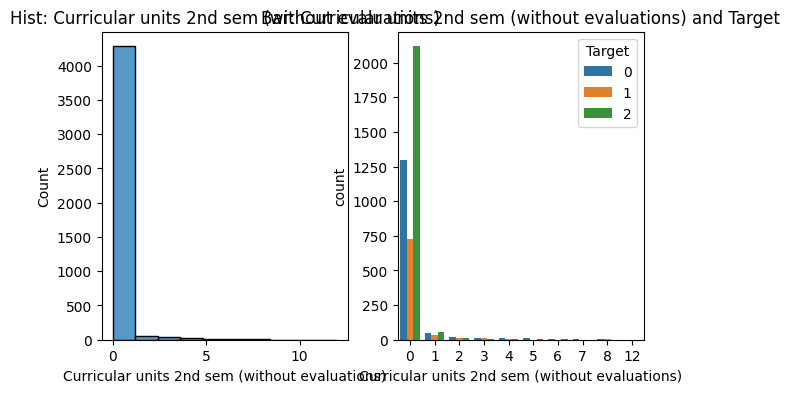

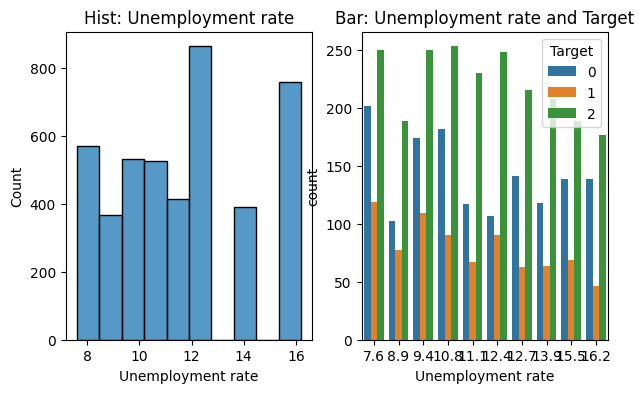

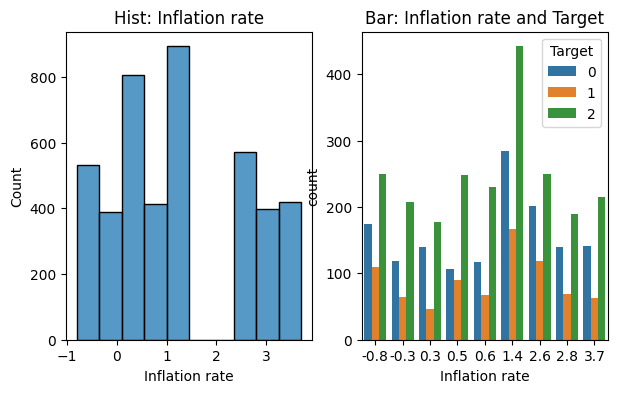

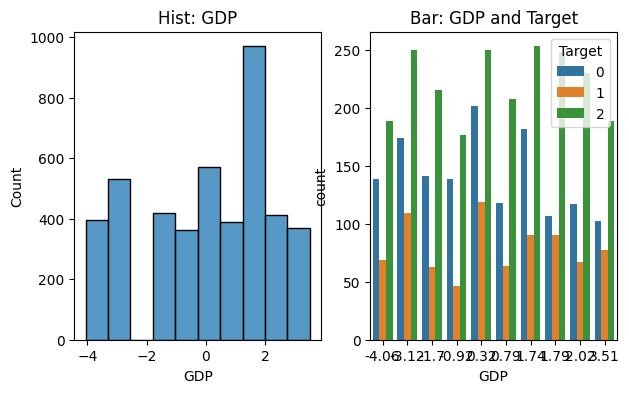

In [8]:
#Looking for interesting callouts
calls = {}
for c in list(raw_df.columns[:-1]):
    calls[c] = {'blanks':{}, 'distribution':{}}
    #blank rows
    count_blanks = raw_df[(raw_df[c].isna() | raw_df[c]=='')].shape[0]
    calls[c]['blanks'] = count_blanks
    #hists
    pair_df = raw_df[[c,'Target']]
    #calls[c]['distribution'] = HistAndBar(pair_df, column=c)[c]
    HistAndBar(pair_df, column=c)
    #plt.show()
    

# Modeling
Since this is a classification problem we will try a couple of ensemble modeling methods: Random Forest and Gradient Boosting.

Why? Both ensemble methods are useful with multi-category classification and can easily handle a variety of inputs. They also have the added bonus of handling inputs without requiring scaling or transformations.

## Scoring KPI
Since we want to correctly predict which students will re-enroll, graduate, or drop out, we need to pick a proper scoring kpi.

Our target variable is relatively imbalanced, so we'll want a metric that doesn't give too much weight to over represented classes.

In this case we'll try out micro-averaging f1 as our primary metric. We'll still consider RMSE for our classes as a secondary metric.

In [17]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

#Local packageZZZ
import utilClassifier
importlib.reload(utilClassifier)  # Reload the module
from utilClassifier import Classifier

clean_df = raw_df.copy()
y = 'Target'
xlist = [x for x in list(clean_df.columns) if x != y] 

##W/O Normalization
#Gradient Boosting
#gparams = {
#    'n_estimators':[250],#[100, 250, 500, 1000],
#    'max_depth': [20],#[1, 10, 20],
#    'subsample':[0.25],#[0.25,0.5,0.8],
#    'max_features':[0.5]#[0.25, 0.5, 0.8]
#}
#gb_class = Classifier(data=clean_df, X=xlist, y=y, 
#                      estimator=GradientBoostingClassifier, 
#                      gparams_dict=gparams,
#                      normalize = False)
#gb_class = gb_class.fitModel().showMetrics()
#gb_class = gb_class.showFeatureImportance()

#RFC
rfparams = {
    "n_estimators":[10,50,100,200],
    "max_depth":[1,5,10,20],#,50,100],
    "min_samples_split":[2,5,10]
}
rf_class = Classifier(data=clean_df, X=xlist, y=y, 
                      estimator=RandomForestClassifier, gparams_dict=rfparams,
                      normalize = False)
rf_class = rf_class.fitModel()

Fitting 5 folds for each of 48 candidates, totalling 240 fits


# Evaluating
Our model is scoring well enough on micro averaged precision and recall. 
- Micro Average of 78% means 3/4 times we make a prediction it's correct.

## Feature Importance
A key output from our model will be feature importance, so users of the model can identify interventions.

How does it work? The model measures the information gain if it were to leave out a particular variable. e.g. If we leave out marital status, how does our model perform? Does it perform better or worse if we leave out a different variable?

In our case we'll want to know the feature importance in order to propose any interventions or key predictors for dropout and graduation. That way we can tell consumers of our model how to improve student graduation rates.

For example "Curricular units approved" in the graph below is key for both 2nd and 1st semester. The [dataset](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) doesn't offer a detailed explanation, so we can only assume what it means. I'd imagine that approved curricular units is how many course units the institution has approved the student to take in the following semester. The registrar could pass this information onto admissions to identify which students could use the most financial help to complete their classes vs. those that would be less likely to complete their courses.

RMSE: 0.6329967863321656
Micro Avg F1: 0.7801369863013699


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


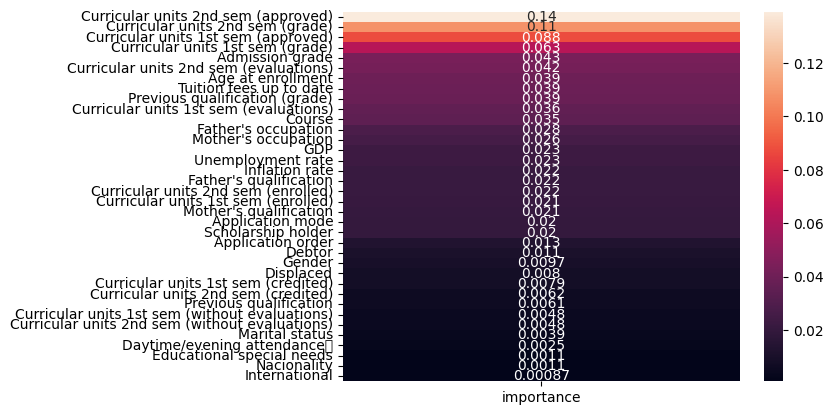

In [18]:
rf_class = rf_class.showMetrics()
rf_class = rf_class.showFeatureImportance()

# Brief Error Analysis

In [20]:
# Get the incorrect predictions with the lowest confidence in their true class
misses = [(i, rf_class.y_test.iloc[i], rf_class.y_preds[i], rf_class.y_proba[i].max()) for i in rf_class.misclassified_idx]

dist_misses = [i[1] for i in misses]

zero = 0
one = 0
two = 0

for m in dist_misses:
    if m == 0:
        zero+=1
    if m == 1:
        one += 1
    if m ==2:
        two += 1

#print(zero)
#print(zero/(zero+one+two))
#print(one)
#print(one/(zero+one+two))
#print(two)
#print(two/(zero+one+two))

least_conf_misses = sorted(misses, key=lambda x: x[3])[:10]  # Least confident misses
highest_conf_misses = sorted(misses, key=lambda x: x[3])[-10:]  # Highest confident misses


for i, true_label, pred_label, confidence in least_conf_misses:
    print(f"Low-Conf -- Index: {i}, True: {true_label}, Predicted: {pred_label}, Confidence: {confidence}")

print("\n")
for i, true_label, pred_label, confidence in highest_conf_misses:
    print(f"High-Conf -- Index: {i}, True: {true_label}, Predicted: {pred_label}, Confidence: {confidence}")

Low-Conf -- Index: 195, True: 1, Predicted: 2, Confidence: 0.00016
Low-Conf -- Index: 755, True: 1, Predicted: 2, Confidence: 0.0015144454799627214
Low-Conf -- Index: 451, True: 0, Predicted: 2, Confidence: 0.02
Low-Conf -- Index: 635, True: 1, Predicted: 2, Confidence: 0.03
Low-Conf -- Index: 148, True: 0, Predicted: 2, Confidence: 0.03016
Low-Conf -- Index: 758, True: 0, Predicted: 2, Confidence: 0.030447635135135136
Low-Conf -- Index: 374, True: 1, Predicted: 2, Confidence: 0.04
Low-Conf -- Index: 431, True: 1, Predicted: 0, Confidence: 0.04
Low-Conf -- Index: 982, True: 1, Predicted: 0, Confidence: 0.04
Low-Conf -- Index: 275, True: 0, Predicted: 2, Confidence: 0.045789518254306986


High-Conf -- Index: 636, True: 0, Predicted: 1, Confidence: 0.53
High-Conf -- Index: 1274, True: 0, Predicted: 1, Confidence: 0.53
High-Conf -- Index: 812, True: 0, Predicted: 1, Confidence: 0.5325
High-Conf -- Index: 829, True: 2, Predicted: 1, Confidence: 0.534
High-Conf -- Index: 5, True: 2, Predict

An error analysis can be helpful to determine how to imnprove if our score isn't good enough. We can look at errors that the model is most confident making and errors that it's least confident making. High confidence could mean overfitting, bad data, or quick tweaks to fix. Low confidence could mean the model is unable to nuance it's decision enough.

The RF model's least confident misses are for Graduates: 2's (who or either still enrolled or dropped out).

The model's most confident misses are with Enrolled: 1's (who are most frequently dropped out).
It's also more likely to get Enrolled: 1's wrong which only make up 17% of our original data, but 50% of our misses (despite stratifying the train/test split). 

Some ways to improve:
- One possibility could be to try to train three different models to predict each target.
- Look for features that correlate with enrolled target and try to weigh those more heavily or find more features similar to that. Engineer features that could push the model further in that regard.

_Quick Note: Since our data is imbalanced, predict_proba will be slightly influenced by this imbalance; subsequently the low/high confidence will also be influenced by this imbalance. It's valuable to remember when considering this error analysis._

## Update (2/18/25)
This month I attempted to produce a meta-model using one-vs-rest models to predict each class and a meta model to ingest those predictions and make a final prediction. Due to the imbalance in classes, it did not perform better than a single RF Classifier, so I left the model as-is. Also, it's not clear that additional revisions will give good roi. With that in mind, I'm closing this analysis out to move onto next projects. Enjoy!